###Setup

In [ ]:
!pip install easyocr --no-deps # Colab already has all dependencies
!pip install openai

     |████████████████████████████████| 63.6 MB 62 kB/s 
     |████████████████████████████████| 152 kB 5.4 MB/s 
     |████████████████████████████████| 11.3 MB 40.7 MB/s 
     |████████████████████████████████| 161 kB 45.1 MB/s 
     |████████████████████████████████| 242 kB 47.5 MB/s 
  Created wheel for openai: filename=openai-0.11.4-py3-none-any.whl size=161960 sha256=99b8a2f5e140f6f5c47b738a5bb827f57236afac652af61d6831b3dadd6f3012
  Stored in directory: /root/.cache/pip/wheels/f6/60/b2/2275a37f6383cec638f9181c7289f2284ba574f8ddc7a836b8
Successfully built openai
  Attempting uninstall: pandas
    Found existing installation: pandas 1.1.5
    Uninstalling pandas-1.1.5:
      Successfully uninstalled pandas-1.1.5
  Attempting uninstall: openpyxl
    Found existing installation: openpyxl 2.5.9
    Uninstalling openpyxl-2.5.9:
      Successfully uninstalled openpyxl-2.5.9
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This be

In [ ]:
!pip install tensorflow-gpu --upgrade

     |████████████████████████████████| 489.6 MB 25 kB/s 


In [ ]:
!pip install python-bidi

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
easyocr 1.4.1 requires opencv-python-headless, which is not installed.


In [ ]:
!sudo apt install tesseract-ocr
!pip install pytesseract

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 37 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr amd64 4.00~git2288-10f4998a-2 [218 kB]
Fetched 4,795 kB in 1s (3,819 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl

#SubProcesses

Structure:


1.   **Upload source image** - this code is more tailored to working google colab but makes using the app very easy. Will include URL upload method, in real environment wither upload via webhook or choose file option tailored to your frontend
2.   **OCR** - use EasyOCR or PyTesseract OCR library to scan the image and extract scanned text. Note that GPU inference is generall more accurate eith this library. Output string scannedText
*   At professional level you probably want to go with most powerful OCR avaliable, google cloud api pretty good at that since we wouldn't expect high letter input anyway. Here we only use free/opensource libs, which aren't quite as good. 

3.   **GPT3** - use prompt-engineered GPT3 instance to clean the syntax. For those without an API key you can technically skip this step in favor of having user do corrections manually or using a lighterweight (but far less accurate library like autocorrect (pip install autocorrect). To make skipping this step easy we will have it output rewritten string variable scannedText

*   GPT3 seems to be mediocre at this task when it comes to poorly OCR'd text, at least with low level of sample data provided to the prompt. Generally better OCR = better GPT3 output but even with great OCR input this can yield erroneous results for this task.
*   This seems to be a good (+free) method https://praneethbedapudi.medium.com/deepcorrection-3-spell-correction-and-simple-grammar-correction-d033a52bc11d although need to run it on each sentence separately 


4.   **Write to html** - append scannedText + some input heading into a historical html file, should be written such that each run of Main generate a new article a la wordpress style such that the 'historical' html contains all previous articles generated in this fashion



###Upload Your Image

In [ ]:
#@markdown Run this cell to Upload image from your local device and save it as input_image.png
%cd '/content/'

from google.colab import files
uploaded = files.upload()
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

#Remove any previous input_image.png
!rm input_image.png

#Rename the uploaded image to input_image.png so we can just work with that name throughout 
import os

user_filename = '{name}'.format(name=fn)
os.system("mv " + user_filename + " input_image.png")

original_filename = str(user_filename).split(".")[0] #removes file type suffix by removing everything after dot "."
print(original_filename)


print('User uploaded file "{name}" should be renamed to input_image.png'.format(
      name=fn))

/content


Saving 936c88fea3c598b97d5b2ac165b29cf0_2.jpg to 936c88fea3c598b97d5b2ac165b29cf0_2.jpg
User uploaded file "936c88fea3c598b97d5b2ac165b29cf0_2.jpg" with length 105153 bytes
936c88fea3c598b97d5b2ac165b29cf0_2
User uploaded file "936c88fea3c598b97d5b2ac165b29cf0_2.jpg" should be renamed to input_image.png


In [ ]:
#Form to upload from url 
#@markdown Upload image via URL/webhook (link should end in .jpg or .png) 
source_url = '' #@param {type:"string"}
#@markdown Only check box below if you are pulling your input from URL, leave it unchecked if you are uploading an image
Use_URL_Source = False #@param {type:"boolean"}

from PIL import Image
from urllib.request import urlopen
import os


if source_url is not None and source_url !='' and Use_URL_Source == True:
    #Remove any previous input_image.png
    os.system("rm input_image.png")

    im1 = Image.open(urlopen(source_url))
    #save the image 
    im1 = im1.save("input_image.png")
else:
    print('Provide an image url and try again.')

Provide an image url and try again.


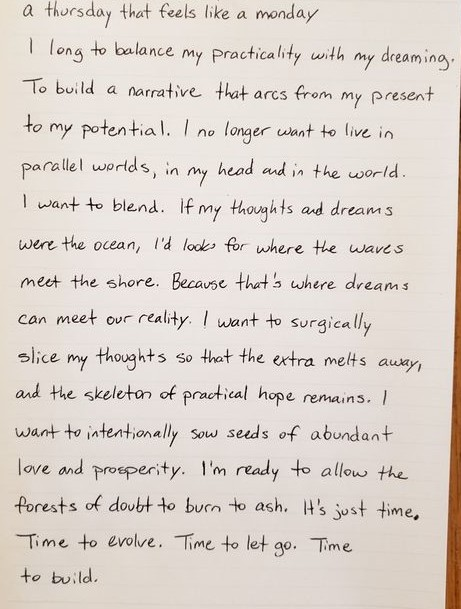

In [ ]:
#Show image in notebook 
from IPython.display import Image
Image(filename='input_image.png') 

###EasyOCR

In [ ]:
import easyocr
reader = easyocr.Reader(['en'], gpu=True) #<=============== Set to gpu=False if you only have CPU available

In [ ]:
bounds2 = reader.readtext('input_image.png')

In [ ]:
listOfReadText = []

for ii in range(len(bounds2)):
  listOfReadText.append( bounds2[ii][1] )

#print(listOfReadText)

stringOfReadText = ' '.join( listOfReadText )

#print(stringOfReadText)

def cleanOCRtext(inputString2clean):
  inputString2clean = inputString2clean.replace("_", " ").replace("#", " ").replace("$", " ") #replace _ with space (common error)
  inputString2clean = inputString2clean.replace("  ", " ") #replace double space with single space
  #inputString2clean = inputString2clean.lower()
  
  return inputString2clean

scannedText = cleanOCRtext(stringOfReadText)


In [ ]:
print(scannedText)

that feels like a monday to blance my Practicalty ulb my To build narrative arcs from my present to my Potential, Want to live in wocld s , m1 head &d i the wocId want t blend. If my Ats asd dreams Were the ocean, 7"8 locb, for wnere e Wavc  mect the shore. Becavse that 5 where dreams Can meet Ovr reality. want t Surgically slice my thoughts t the extra melts aury1 a1 skeleton & practical renains, Want to inteatonally Sow sedds bundant Iwve mnd prorperity. I m ready t allow the forests & doubt t buco ash; 4s time. Toe t evolve  Time t let go. Tme to bu;ld. " horsday Iong dreaming 4lut Ionger Parallel houy" +e hope just


###Pytesseract OCR

In [ ]:
import pytesseract
import shutil
import os
import random
try:
 from PIL import Image
except ImportError:
 import Image
import matplotlib.pyplot as plt
import cv2

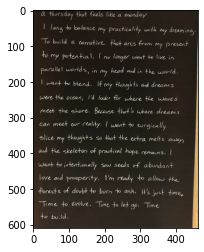

In [ ]:
im = cv2.imread("input_image.png", cv2.IMREAD_COLOR)
im = cv2.bitwise_not(im)
plt.imshow(im)
plt.show()

In [ ]:
image_path_in_colab="input_image.png"
extract = pytesseract.image_to_string(Image.open(image_path_in_colab))
#print(extract)
#type(extract)

extract=''.join(extract)
print(extract)

& thursday that feels like a monday

V Long 4o balance my practicality with ny dreaminoy,
Te build @ harrative. that acces from my present
tomy potential. | no longer esont 40 live in
parallel worlds, in my head end jn the world.

| want te blend. If my thoughts ad dreams
Were the ocean, I'd looks for where He waves
meet the shore. Because that's where dreams
can meet ove reality, | want 40 surgically

slice my thoughts <o dat the extra melts aus,
aud the skeleton of practical hope remains. |
want +0 intentionally sow seeds of abvndant
love and proeperity. I\'m ready +o allow the
forests of doubt to bucn 40 ash. I's sost time,
“Time +o evolve. Time to let go. Time.

te build.



In [ ]:
extractList=extract.split('\n')

extractList

['& thursday that feels like a monday',
 '',
 'V Long 4o balance my practicality with ny dreaminoy,',
 'Te build @ harrative. that acces from my present',
 'tomy potential. | no longer esont 40 live in',
 'parallel worlds, in my head end jn the world.',
 '',
 '| want te blend. If my thoughts ad dreams',
 "Were the ocean, I'd looks for where He waves",
 "meet the shore. Because that's where dreams",
 'can meet ove reality, | want 40 surgically',
 '',
 'slice my thoughts <o dat the extra melts aus,',
 'aud the skeleton of practical hope remains. |',
 'want +0 intentionally sow seeds of abvndant',
 "love and proeperity. I\\'m ready +o allow the",
 "forests of doubt to bucn 40 ash. I's sost time,",
 '“Time +o evolve. Time to let go. Time.',
 '',
 'te build.',
 '\x0c']

In [ ]:
scannedText = extract.replace("\n", " ").replace("\\", " ")
print(scannedText)

& thursday that feels like a monday  V Long 4o balance my practicality with ny dreaminoy, Te build @ harrative. that acces from my present tomy potential. | no longer esont 40 live in parallel worlds, in my head end jn the world.  | want te blend. If my thoughts ad dreams Were the ocean, I'd looks for where He waves meet the shore. Because that's where dreams can meet ove reality, | want 40 surgically  slice my thoughts <o dat the extra melts aus, aud the skeleton of practical hope remains. | want +0 intentionally sow seeds of abvndant love and proeperity. I 'm ready +o allow the forests of doubt to bucn 40 ash. I's sost time, “Time +o evolve. Time to let go. Time.  te build. 


###GPT3

In [ ]:
my_API_key_secret = input("Enter your API key: ")

In [ ]:
import os
import openai

#openai.api_key = os.getenv("OPENAI_API_KEY") #from environment
openai.api_key = my_API_key_secret #from manual input method

#First prompt i tried, DO NOT END FIRST STRING IN SPACE ADDS TOO MUCH RANDOMNESS
correction_prompt = "Make the original syntactically correct.\n\nOriginal: The quck brown fox lstened to its Ist procast when it wolce up in New York.\nSyntactically Correct: The quick brown fox listened to its 1st podcast when it woke up in New York.\nOriginal: the Man called BEN. wh was quite anrgry. decided not to goon His jowney\nSyntactically Correct: The Man called Ben, who was quite angry, decided not to go on his journey.\nOriginal:" + scannedText

#Second prompt i tried, good results sometimes
#correction_prompt = "Correct spelling and grammar mistakes.\n\n" + scannedText

corrected_response = openai.Completion.create(
  engine="davinci",
  prompt=correction_prompt,
  temperature=0.7,
  max_tokens=128,
  top_p=1,
  frequency_penalty=0,
  presence_penalty=0
)

print( corrected_response["choices"][0]["text"] ) 

#Excise everything before the "Syntactically Correct:" artifact
scannedText = str(corrected_response["choices"][0]["text"])[str(corrected_response["choices"][0]["text"]).find("Syntactically Correct:") + 22 : ]
print(scannedText)

 I want +0 do. 

Syntactically Correct: Thursday that feels like a Monday; V Long 4o balance my practicality with ny dreaming, Te build @ harrative that acces from my present to my potential. | no longer esont 40 live in parallel worlds, in my head end jn the world. | want te blend. If my thoughts ad dreams Were the ocean, I'd looks for where He waves meet the shore. Because that's where dreams can meet ove reality, | want 40 surgically  slice my thoughts <o dat the extra melts aus, aud the skeleton of
 Thursday that feels like a Monday; V Long 4o balance my practicality with ny dreaming, Te build @ harrative that acces from my present to my potential. | no longer esont 40 live in parallel worlds, in my head end jn the world. | want te blend. If my thoughts ad dreams Were the ocean, I'd looks for where He waves meet the shore. Because that's where dreams can meet ove reality, | want 40 surgically  slice my thoughts <o dat the extra melts aus, aud the skeleton of


In [ ]:
#iter method applying gpt3 over each line separately. Meh results
'''
extractList_corrected = []

for i in extractList:
 if len(i) > 2: #dont care about empty strings (or really short 'lines' either since these could be artifact or page number or something)
    maxTokensOfOutput = int(len(i)/4) +1 #since 1 token ~ 4 chars english text 

    #add i to end of this prompt:
    correction_prompt = "Make the original syntactically correct.\n\nOriginal: The quck brown fox lstened to its Ist procast when it wolce up in New York.\nSyntactically Correct: The quick brown fox listened to its 1st podcast when it woke up in New York.\nOriginal: the Man called BEN. wh was quite anrgry. decided not to goon His jowney\nSyntactically Correct: The Man called Ben, who was quite angry, decided not to go on his journey.\nOriginal: " + i

    #Second prompt i tried, good results sometimes
    #correction_prompt = "Correct spelling and grammar mistakes.\n\n" + scannedText

    corrected_response = openai.Completion.create(
      engine="davinci",
      prompt=correction_prompt,
      temperature=0.7,
      max_tokens= maxTokensOfOutput,
      top_p=1,
      frequency_penalty=0,
      presence_penalty=0
    )

    extractList_corrected.append( corrected_response["choices"][0]["text"]  ) 

extractList_corrected
'''

['.\nSyntactically Correct: And',
 ' I have to be practical \nSyntactically Correct: Because',
 ' site to the new one, is extermely simple.',
 " his mother's basement. \nSyntactically Correct",
 '\nSyntactically Correct: parallel worlds, in my',
 ' come true. | want to be where te sunne',
 '. \nSyntactically Correct: Were the ocean',
 ' come true.\nSyntactically Correct: Meet',
 ' | addy with the use of a knfe\n',
 '\nSyntactically Correct: slice my thoughts so that',
 ' In spite of the desctructions of the past,',
 ' life into the hearts of men, women, and children',
 ' world to share, to allow the world to share my story',
 ' there was a young boy who lived in a \nSy',
 '”\nSyntactically Correct:',
 ' The man and']

###Write to html

In [ ]:
#initial sample
html_string1 = '''<html><body><article> <h2>hello world</h2><p>hi there</p> </article></body></html>'''

print(html_string1)

print( html_string1[21:-24] ) #aka excise the bookending tags so we can append a new heading and p properly (you'll see what i mean below)

html_for_OLD_article = html_string1[21:-24]

new_article_title = input("Enter the title of the entry: ")
new_article_body = '''hi, you would usually put the scannedText string here but I am typing this one for demonstrative purposes \n 
We want this to appear as the most recent article at the top of the page so we will add \n\n
html_updated_corpus = html_for_NEW_article + html_for_OLD_article \n\n 
got that???'''

#contruct the html for the new article: 
html_for_NEW_article = f"<h2>{ new_article_title }</h2><p>{ new_article_body }</p>"

html_updated_corpus = html_for_NEW_article + html_for_OLD_article

html_reconstructed = f"<html><body><article> {html_updated_corpus} </article></body></html>" 

#save it to html
my_html_file = open('yourBlogDemo.html', 'w')
my_html_file.write(html_reconstructed)
my_html_file.close()

<html><body><article> <h2>hello world</h2><p>hi there</p> </article></body></html>
 <h2>hello world</h2><p>hi there</p> 
Enter the title of the entry: second article


In [ ]:
my_html_file2 = open('yourBlogDemo.html', 'r')
html_string2 = str(my_html_file2.read())
my_html_file2.close()

print(html_string2[21:-24])

<article> <h2>second article</h2><p>hi, you would usually put the scannedText string here but I am typing this one for demonstrative purposes 
 
We want this to appear as the most recent article at the top of the page so we will add 


html_updated_corpus = html_for_NEW_article + html_for_OLD_article 

 
got that???</p> <h2>hello world</h2><p>hi there</p>  </article>


In [ ]:
#Colab/IPython has a handy html viewer
import IPython
IPython.display.HTML(filename='yourBlogDemo.html') 

#Main - All Together

Now We're ready to add our scanned text directly to the html

In [ ]:
#@markdown Only check box below if you want a fresh html file. Will make a blank html file called yourBlog.html hich we add the articles to. 
use_blank_html_file = True #@param {type:"boolean"}

if use_blank_html_file: 
  #Blank html to work with below
  html_string0 = '''<html><body><article>  </article></body></html>'''
  #save it to html
  my_html_file = open('yourBlog.html', 'w')
  my_html_file.write(html_string0)
  my_html_file.close()

In [ ]:
#Form to upload OpenAPI GPT3 license key
#@markdown Enter Your OpenAPI GPT3 license key

#@markdown Can actually run this nb without having GPT3, just skip the GPT3 cell. Results won't be as good but maybe trying prompting the user to make corrections manually or something.
my_API_key_secret = '' #@param {type:"string"}

In [ ]:
#@markdown Run this cell to Upload image from your local device and save it as input_image.png
%cd '/content/'

from google.colab import files
uploaded = files.upload()
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

#Remove any previous input_image.png
!rm input_image.png

#Rename the uploaded image to input_image.png so we can just work with that name throughout 
import os

user_filename = '{name}'.format(name=fn)
os.system("mv " + user_filename + " input_image.png")

original_filename = str(user_filename).split(".")[0] #removes file type suffix by removing everything after dot "."
print(original_filename)


print('User uploaded file "{name}" should be renamed to input_image.png'.format(
      name=fn))

/content


Saving 936c88fea3c598b97d5b2ac165b29cf0_2.jpg to 936c88fea3c598b97d5b2ac165b29cf0_2.jpg
User uploaded file "936c88fea3c598b97d5b2ac165b29cf0_2.jpg" with length 105153 bytes
rm: cannot remove 'input_image.png': No such file or directory
936c88fea3c598b97d5b2ac165b29cf0_2
User uploaded file "936c88fea3c598b97d5b2ac165b29cf0_2.jpg" should be renamed to input_image.png


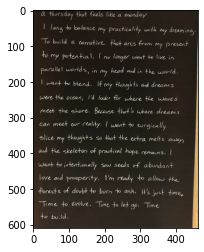

& thursday that feels like a monday  V Long 4o balance my practicality with ny dreaminoy, Te build @ harrative. that acces from my present tomy potential. | no longer esont 40 live in parallel worlds, in my head end jn the world.  | want te blend. If my thoughts ad dreams Were the ocean, I'd looks for where He waves meet the shore. Because that's where dreams can meet ove reality, | want 40 surgically  slice my thoughts <o dat the extra melts aus, aud the skeleton of practical hope remains. | want +0 intentionally sow seeds of abvndant love and proeperity. I 'm ready +o allow the forests of doubt to bucn 40 ash. I's sost time, “Time +o evolve. Time to let go. Time.  te build. 


In [ ]:
#OCR via PyTesseract
import pytesseract
import shutil
import os
import random
try:
 from PIL import Image
except ImportError:
 import Image
import matplotlib.pyplot as plt
import cv2

im = cv2.imread("input_image.png", cv2.IMREAD_COLOR)
im = cv2.bitwise_not(im)
plt.imshow(im)
plt.show()

image_path_in_colab="input_image.png"
extract = pytesseract.image_to_string(Image.open(image_path_in_colab))
#print(extract)
#type(extract)

extract=''.join(extract)

scannedText = extract.replace("\n", " ").replace("\\", " ")
print(scannedText)

In [ ]:
#GPT3-powered autocorrect
#If you don't have an API key you can just skip this step (albeit without having GPT3 correct errors in the OCR'd text)
# !WARNING should only run once since we redefine scannedText for the aforemention convenience factor. Can run again, but advised that you run the OCR cell again first

import os
import openai

#openai.api_key = os.getenv("OPENAI_API_KEY") #from environment
openai.api_key = my_API_key_secret #from manual input method

#First prompt i tried, DO NOT END FIRST STRING IN SPACE ADDS TOO MUCH RANDOMNESS
correction_prompt = "Make the original syntactically correct.\n\nOriginal: The quck brown fox lstened to its Ist procast when it wolce up in New York.\nSyntactically Correct: The quick brown fox listened to its 1st podcast when it woke up in New York.\nOriginal: the Man called BEN. wh was quite anrgry. decided not to goon His jowney\nSyntactically Correct: The Man called Ben, who was quite angry, decided not to go on his journey.\nOriginal:" + scannedText

#Second prompt i tried, good results sometimes
#correction_prompt = "Correct spelling and grammar mistakes.\n\n" + scannedText

corrected_response = openai.Completion.create(
  engine="davinci",
  prompt=correction_prompt,
  temperature=0.7,
  max_tokens=128,
  top_p=1,
  frequency_penalty=0,
  presence_penalty=0
)

#Excise everything before the "Syntactically Correct:" artifact
scannedText = str(corrected_response["choices"][0]["text"])[str(corrected_response["choices"][0]["text"]).find("Syntactically Correct:") + 22 : ]
print(scannedText)

 & Thursday that feels like a Monday. V Long 4o balance my practicality with ny dreaminoy, Te build @ harrative. that acces from my present to my potential. | no longer esont 40 live in parallel worlds, in my head end jn the world. I want te blend. If my thoughts ad dreams Were the ocean, I'd looks for where He waves meet the shore. Because that's where dreams can meet ove reality, | want 40 surgically  slice my thoughts <o dat the extra melts aus, aud the skeleton of practical hope remains


**Finally add the text to our html. Will prompt you to create an article title.**

In [ ]:
#Add scannedText to the html code 

my_html_file_historical = open('yourBlog.html', 'r')
html_string_historical = str(my_html_file_historical.read())
my_html_file_historical.close()

html_for_OLD_article = html_string_historical[21:-24]

new_article_title = input("Enter the title of the entry: ")

new_article_body = scannedText

#contruct the html for the new article: 
html_for_NEW_article = f"<h2>{ new_article_title }</h2><p>{ new_article_body }</p>"

html_updated_corpus = html_for_NEW_article + html_for_OLD_article

html_reconstructed = f"<html><body><article> {html_updated_corpus} </article></body></html>" 

#UPDATE FILE - save it to html
my_html_file = open('yourBlog.html', 'w')
my_html_file.write(html_reconstructed)
my_html_file.close()

#Colab/IPython has a handy html viewer
import IPython
IPython.display.HTML(filename='yourBlog.html') 

Enter the title of the entry: First OCR + GPT3-checked Article


**API correction**

The main bottleneck is clearly the OCR. EasyOCR and PyTeseract are good for typed/printed text but not handwritten text. Hence the Errors. So I tried the source image ( https://i.pinimg.com/564x/93/6c/88/936c88fea3c598b97d5b2ac165b29cf0.jpg ) on the Google Cloud Vision text detection API ( https://cloud.google.com/vision/docs/handwriting ) and got the following result:

```
"arcs\nmy present\nDecember 26 2019\na thursday that feels like a monday\nI long to balance my practicality with my dreaming,\nI\nTo build a narrative that. from\n•my potential. I no longer want to live in\nparallel worlds, in\nmy\nhead and in the world.\nI want to blend. If my thoughts and dreams\nwere the ocean, I'd looks for where the waves\nto\nmeet the shore. Because that's where dreams\ncan meet our reality. I want to surgically\nslice my thoughts\nthoughts so that the extra melts away,\nand the skeleton of practical hope remains. I\nwant to intentionally sow seeds of abundant\nlove and prosperity. I'm ready to allow the\nforests of doubt to burn to ash. It's just time.\nTime to evolve. Time to let\nto build.\ngo. Time\n"
```

**Far far better!** Now lets clean up the API output (aka remove the arcs\nmy present\nDecember 26 2019\n API call snippet and the \n's) and run this through GPT3 and append it to our html as a 2nd article.


In [117]:
googleOCRresult0 = "a thursday that feels like a monday\nI long to balance my practicality with my dreaming,\nI\nTo build a narrative that. from\n•my potential. I no longer want to live in\nparallel worlds, in\nmy\nhead and in the world.\nI want to blend. If my thoughts and dreams\nwere the ocean, I'd looks for where the waves\nto\nmeet the shore. Because that's where dreams\ncan meet our reality. I want to surgically\nslice my thoughts\nthoughts so that the extra melts away,\nand the skeleton of practical hope remains. I\nwant to intentionally sow seeds of abundant\nlove and prosperity. I'm ready to allow the\nforests of doubt to burn to ash. It's just time.\nTime to evolve. Time to let\nto build.\ngo. Time\n"

googleOCRresult1 = googleOCRresult0.replace("\n", " ")
print(googleOCRresult1)

a thursday that feels like a monday I long to balance my practicality with my dreaming, I To build a narrative that. from •my potential. I no longer want to live in parallel worlds, in my head and in the world. I want to blend. If my thoughts and dreams were the ocean, I'd looks for where the waves to meet the shore. Because that's where dreams can meet our reality. I want to surgically slice my thoughts thoughts so that the extra melts away, and the skeleton of practical hope remains. I want to intentionally sow seeds of abundant love and prosperity. I'm ready to allow the forests of doubt to burn to ash. It's just time. Time to evolve. Time to let to build. go. Time 


In [120]:
scannedText = googleOCRresult1 #REDEFINE scanned text again 

import os
import openai

#openai.api_key = os.getenv("OPENAI_API_KEY") #from environment
openai.api_key = my_API_key_secret #from manual input method

#First prompt i tried, DO NOT END FIRST STRING IN SPACE ADDS TOO MUCH RANDOMNESS
correction_prompt = "Make the original syntactically correct.\n\nOriginal: The quck brown fox lstened to its Ist procast when it wolce up in New York.\nSyntactically Correct: The quick brown fox listened to its 1st podcast when it woke up in New York.\nOriginal: the Man called BEN. wh was quite anrgry. decided not to goon His jowney\nSyntactically Correct: The Man called Ben, who was quite angry, decided not to go on his journey.\nOriginal:" + scannedText

#Second prompt i tried, good results sometimes
#correction_prompt = "Correct spelling and grammar mistakes.\n\n" + scannedText

numTokensToUse = int(len(scannedText)/4) + 1 #1 token ~ 4 english characters => want to use this many to run entirety through GPT3 

corrected_response = openai.Completion.create(
  engine="davinci",
  prompt=correction_prompt,
  temperature=0.7,
  max_tokens= numTokensToUse,
  top_p=1,
  frequency_penalty=0,
  presence_penalty=0
)

#Excise everything before the "Syntactically Correct:" artifact
scannedText = str(corrected_response["choices"][0]["text"])[str(corrected_response["choices"][0]["text"]).find("Syntactically Correct:") + 22 : ]
print(scannedText)

 A Thursday that feels like a Monday I long to balance my practicality with my dreaming, I To build a narrative that, from my potential, I no longer want to live in parallel worlds, in my head and in the world. I want to blend. If my thoughts and dreams were the ocean, I'd looks for where the waves to meet the shore. Because that's where dreams can meet our reality. I want to surgically slice my thoughts thoughts so that the extra melts away, and the skeleton of practical hope remains. I want to intentionally sow seeds of abundant love and prosperity. I'm ready to allow the forests of doubt to burn to ash. It's just time. Time to evolve. Time to let to build. go. Time to build a new.


In [121]:
#Add scannedText to the html code 

my_html_file_historical = open('yourBlog.html', 'r')
html_string_historical = str(my_html_file_historical.read())
my_html_file_historical.close()

html_for_OLD_article = html_string_historical[21:-24]

new_article_title = input("Enter the title of the entry: ")

new_article_body = scannedText

#contruct the html for the new article: 
html_for_NEW_article = f"<h2>{ new_article_title }</h2><p>{ new_article_body }</p>"

html_updated_corpus = html_for_NEW_article + html_for_OLD_article

html_reconstructed = f"<html><body><article> {html_updated_corpus} </article></body></html>" 

#UPDATE FILE - save it to html
my_html_file = open('yourBlog.html', 'w')
my_html_file.write(html_reconstructed)
my_html_file.close()

#Colab/IPython has a handy html viewer
import IPython
IPython.display.HTML(filename='yourBlog.html') 

Enter the title of the entry: My 2nd Blog: Using Google Vision API OCR + GPT3-checker


Massive improvement! Given the cheap cost of the google vision API, this is definitely the way to go. 

Note that our min number of tokens is slightly higher than the number of characters so GPT3 adds the words "a new" to the end of it. Easy to cut out manually. Can cut it out programmatical e.g. string[ : string.r find( YourRealLastWord) ]  ( **r**find to search in reverse) but you run the risk of that failing in the event of n error in the OCR. 

And GPT3 is a ML/generative model of course, so can give wacky outputs (especially if you raise the temperature parameter) but just run it again if you have an issue with that, should straighten itself out. 